In [0]:
!pip install pyspark

In [0]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')
#os.mkdir('finmod')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml import regression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as fn
from datetime import datetime, timedelta
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Using TensorFlow backend.


In [0]:
#reading data
stock_df = spark.read.csv('snp500datafinal.csv', header=True, inferSchema=True)

In [0]:
atrm = stock_df.where(fn.col('ticker')=='ABT')
atrm = atrm.select('close','date')

In [0]:
atrm = atrm.withColumn("id",fn.monotonically_increasing_id())

In [0]:
atrm.show(10)

+-----+----------+---+
|close|      date| id|
+-----+----------+---+
|32.05|02-01-2013|  0|
|33.27|03-01-2013|  1|
|33.07|04-01-2013|  2|
|33.34|07-01-2013|  3|
|33.35|08-01-2013|  4|
|33.57|09-01-2013|  5|
|33.85|10-01-2013|  6|
|33.37|11-01-2013|  7|
|33.36|14-01-2013|  8|
|33.02|15-01-2013|  9|
+-----+----------+---+
only showing top 10 rows



In [0]:
#creating train and test sets
lent = atrm.count()
itrain = int(0.8*lent)
train = atrm.where(fn.col('id')<itrain)
valid = atrm.where(fn.col('id')>=itrain)
train = train.select('close').collect()
train = [float(row.close) for row in train]
valid = valid.select('close').collect()
valid = [float(row.close) for row in valid]

In [0]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
data = train.copy()
data.extend(valid)
dat=np.reshape(data,(-1,1))
scaled_data = scaler.fit_transform(dat)

In [0]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
 - 59s - loss: 0.0015
Epoch 2/2
 - 57s - loss: 7.2425e-04


In [0]:
#predicting 246 values, using past 60 from the train data
inputs = dat[len(dat) - len(valid) - 60:]
inputs = np.array(inputs)
# inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [0]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
# preds=np.array(preds)
# preds=preds.reshape(1,-1)
# preds = scaler.inverse_transform(preds)
# preds

7.4538965107854445

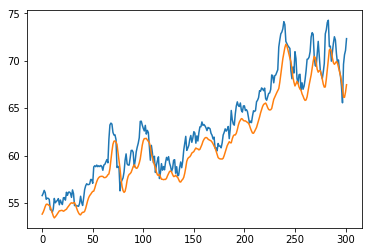

In [0]:
plt.plot(valid)
plt.plot(closing_price)
plt.show()

In [0]:
#defining lists for results and failures in fetching data
results=[]
failed=[]

In [0]:

def make_model(atrm,model_name):
  try:
    #creating train and test sets
    lent = atrm.count()
    itrain = int(0.7*lent)
    train = atrm.where(fn.col('id')<itrain)
    valid = atrm.where(fn.col('id')>=itrain)
    train = train.select('close').collect()
    train = [float(row.close) for row in train]
    valid = valid.select('close').collect()
    valid = [float(row.close) for row in valid]
    #converting dataset into x_train and y_train
    data = train.copy()
    data.extend(valid)
    dat=np.reshape(data,(-1,1))
    #defining scaler and scaling data points in range of 0 to 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dat)
    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    #creating lstm model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)
    filename= model_name+".h5"
    model.save('finmod/'+filename)
    #predicting 1 years stock prices, using past 60 from the train data and validating
    #creating input and output test data
    inputs = dat[len(dat) - len(valid) - 60:]
    inputs = np.array(inputs)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    #predicting on test data
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    results.append({"ticker":model_name,"rmse":rms})
    print(rms)
  except IndexError:
    failed.append(model_name)
  except ValueError:
    failed.append(model_name)
  

In [0]:
for val,x in enumerate(snpticks):
  atrm = stock_df.where(fn.col('ticker')==x)
  atrm = atrm.select('close','date')
  atrm = atrm.withColumn("id",fn.monotonically_increasing_id())
  print(val,x)
  make_model(atrm,x)
  

In [0]:
# !unzip /content/models.zip /content/models/
import zipfile
os.mkdir('finmod')
with zipfile.ZipFile("/content/finmod.zip","r") as zip_ref:
    zip_ref.extractall("/content/finmod/")

In [0]:
!zip -r /content/finmod.zip /content/finmod 
from google.colab import files
files.download("/content/finmod.zip")

In [0]:
os.rmdir('finmod')

In [0]:
snpfin=['AAPL','GOOGL','MSFT','BAC','NFLX','NKE','AET','MS','AMZN','CVS','EXPE','GAP']
os.mkdir("plots")

In [0]:
def validate():
  resultvalid=[]
  filenames=[]
  for root, dirs, files in os.walk("/content/finmod/"):  
    for filename in files:
      filenames.append(filename)
  for stockmodel in filenames:
    x=stockmodel[:-3]
    print(x)
    atrm = stock_df.where(fn.col('ticker')==x)
    atrm = atrm.select('close','date')
    atrm = atrm.withColumn("id",fn.monotonically_increasing_id())
    #creating train and test sets
    lent = atrm.count()
    itrain = int(0.7*lent)
    train = atrm.where(fn.col('id')<itrain)
    valid = atrm.where(fn.col('id')>=itrain)
    train = train.select('close').collect()
    train = [float(row.close) for row in train]
    valid = valid.select('close').collect()
    valid = [float(row.close) for row in valid]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = atrm.select('close').collect()
    dat=np.reshape(data,(-1,1))
    scaled_data = scaler.fit_transform(dat)
    model=load_model("finmod/"+stockmodel)
    #predicting 246 values, using past 60 from the train data
    inputs = dat[len(dat) - len(valid) - 60:]
    inputs = np.array(inputs)
    # inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    resultvalid.append({"ticker":x,"rmse":rms})
    plt.plot()
    plt.plot(valid,'-b',label='Test')
    plt.plot(closing_price,'-r',label='Prediction')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title(x)
    plt.show()
    plt.savefig("plots/"+x+'.png')
    plt.show()
  return resultvalid
  
        

In [0]:
x=validate()

In [0]:
x

In [0]:
def recommend(month,day,year,stocks):
  results=[]
  filenames=[]
  #making filenames
  for x in stocks:
    filenames.append(x+".h5")
  #using all the saved models to get recommendations
  for stockmodel in filenames:
    x=stockmodel[:-3]
    print(x)
    atrm = stock_df.where(fn.col('ticker')==x)
    atrm = atrm.select('close','date')
    atrm = atrm.withColumn("id",fn.monotonically_increasing_id())
    #defining scaler and scaling data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dat)
    data=atrm.select('close').collect()
    dat=np.reshape(data,(-1,1))
    model=load_model("finmod/"+stockmodel)
    #getting data of previous 60 values for given date
    dt=day+"-"+month+"-"+year
    idx=atrm.where(fn.col('date')==dt).select('id').collect()[0][0]
    X_test=atrm.where(fn.col('id')<idx)
    X_test=X_test.where(fn.col('id')>=idx-60)
    inputs=X_test.select('close').collect()
    y=inputs
    inputs = np.reshape(inputs,(-1,1))
    inputs  = scaler.transform(inputs)
    X_test = np.array([inputs])
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    #predicting that day's stock price
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    close=closing_price[0][0]
    open=y[0][-1]
    return_value=(close-open)/open
    #collecting all the return values
    results.append({"ticker":x,"return":return_value})
  
  #ranking stocks based on return values
  results=sorted(results, key = lambda i: i['return'],reverse=True)
  return results

In [0]:
import pickle
import os
from datetime import datetime
dt=datetime.strptime('04-10-09', '%d-%m-%y')

In [0]:
#testing the function
res=recommend('10','04','2017',['AMZN', 'AAPL', 'EXPE', 'CVS', 'BAC', 'GOOGL'])

In [0]:
#displaying results
res

In [0]:
lis=[{'return': -0.050563465255895855, 'ticker': 'AMZN'},
 {'return': 0.007604431894680213, 'ticker': 'AAPL'},
 {'return': -0.11503653788989553, 'ticker': 'EXPE'},
 {'return': 0.038003987347201416, 'ticker': 'CVS'},
 {'return': 0.033118178204792244, 'ticker': 'BAC'},
 {'return': 0.013328255641209534, 'ticker': 'GOOGL'}]
sorted(lis, key = lambda i: i['return'],reverse=True)

In [0]:
def recommend(stocks):
  resultvalid=[]
  filenames=[]
  for x in stocks:
    filenames.append(x+".h5")
  for stockmodel in filenames:
    try:
      x=stockmodel[:-3]
      print(x)
      atrm = stock_df.where(fn.col('ticker')==x)
      atrm = atrm.select('close','date')
      atrm = atrm.withColumn("id",fn.monotonically_increasing_id())
      #converting dataset into x_train and y_train
      scaler = MinMaxScaler(feature_range=(0, 1))
      data=atrm.select('close').collect()
      dat=np.reshape(data,(-1,1))
      scaled_data = scaler.fit_transform(dat)
      model=load_model("finmod/"+stockmodel)
      #predicting 246 values, using past 60 from the train data
      inputs=spark.read.csv(x+'.csv', header=True, inferSchema=True)
      inputs=inputs.select('close').collect()
      inputs = np.reshape(inputs,(-1,1))
      inputs  = scaler.transform(inputs)
      X_test = np.array([inputs[:-1]])
      X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
      closing_price = model.predict(X_test)
      closing_price = scaler.inverse_transform(closing_price)
      close=closing_price[0][0]
      resultvalid.append({"ticker":x,"close":close})
    except ValueError:
      continue
#   resultvalid=sorted(resultvalid, key = lambda i: i['return'],reverse=True)
  return resultvalid

In [0]:
stocks=['AAPL','CVS','BAC','AMD']
z=recommend('10','04','2017',stocks)

In [0]:
z